In [1]:
#To run an unsupervised classification on satellite data using Python you need GDAL, Numpy and Sklearn.
#If you wish to see the data you will also need Matplotlib.
#Assuming you have the libraries installed, import them at the start. 

#Lets start with a single band image

import os
os.getcwd()

'/Users/roman_permyakov/python_projects/Landsat_my_code'

In [2]:
os.chdir("/Users/roman_permyakov/python_projects/Landsat_my_code/Source_img")

In [3]:
os.getcwd()

'/Users/roman_permyakov/python_projects/Landsat_my_code/Source_img'

In [4]:
import numpy as np
from sklearn import cluster
from osgeo import gdal, gdal_array

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in raster image 
img_ds = gdal.Open('l5_Bangalore2011_raw.tif', gdal.GA_ReadOnly)

band = img_ds.GetRasterBand(2)

img = band.ReadAsArray()
print (img.shape)

X = img.reshape((-1,1))
print (X.shape)


k_means = cluster.KMeans(n_clusters=8)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img.shape)

print (len(X_cluster))

(2054, 2044)
(4198376, 1)
2054


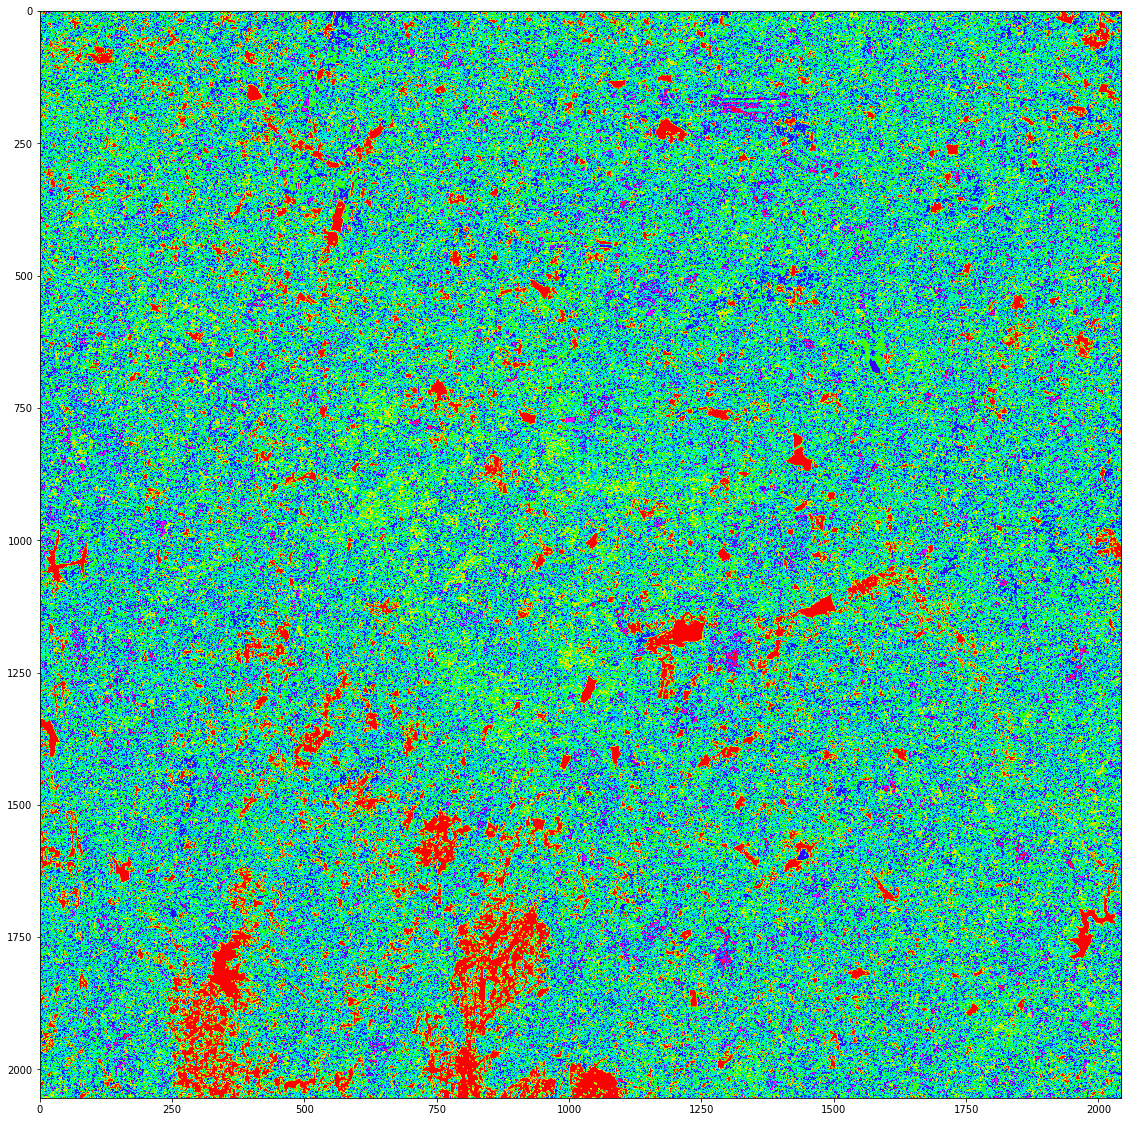

In [5]:
%matplotlib inline  

import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")

plt.show()

In [14]:
from pyrsgis import raster
ds1, featuresBangalore = raster.read('l5_Bangalore2011_raw.tif', bands='all')
nBands = featuresBangalore.shape[0]
print(nBands)

6


In [16]:
#What about using all 6 bands of Landsat 8?

import numpy as np
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in raster image 
img_ds = gdal.Open('l5_Bangalore2011_raw.tif', gdal.GA_ReadOnly)


img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
print (img.shape)

print (new_shape)


X = img[:, :, :6].reshape(new_shape)

print (X.shape)

(2054, 2044, 6)
(4198376, 6)
(4198376, 6)


In [17]:
# Fit it
k_means = cluster.KMeans(n_clusters=8)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

(2054, 2044)


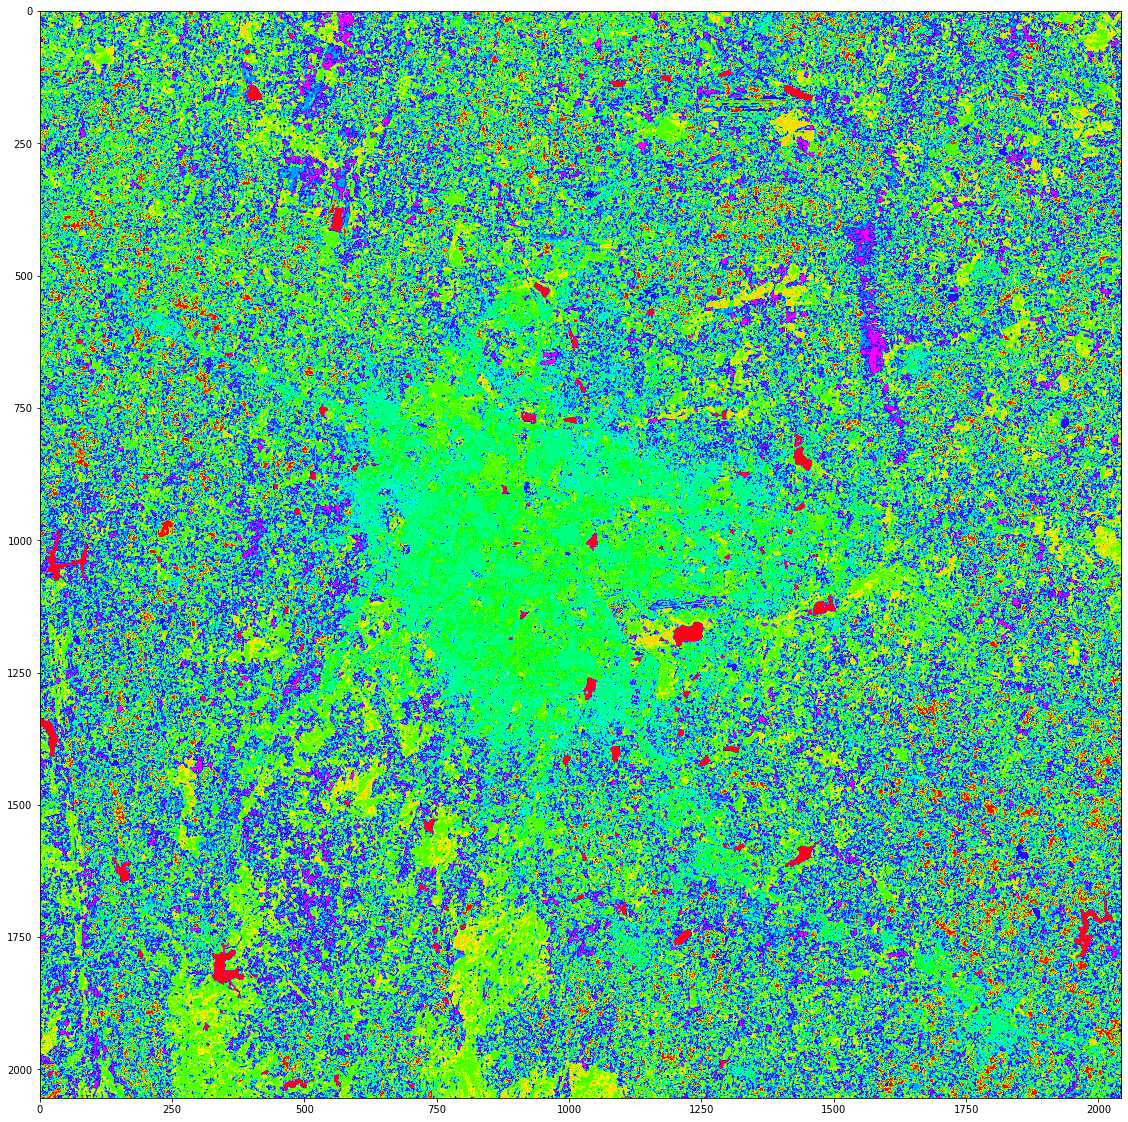

In [19]:
# Plot it
%matplotlib inline  

import matplotlib.pyplot as plt
print (X_cluster.shape)

plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")

plt.show()

In [20]:
# Changing the classification is straight forward. In this example choose MiniBatchKMeans
MB_KMeans = cluster.MiniBatchKMeans(n_clusters=8)
MB_KMeans.fit(X)

X_cluster = MB_KMeans.labels_

X_cluster = X_cluster.reshape(img[:, :, 0].shape)

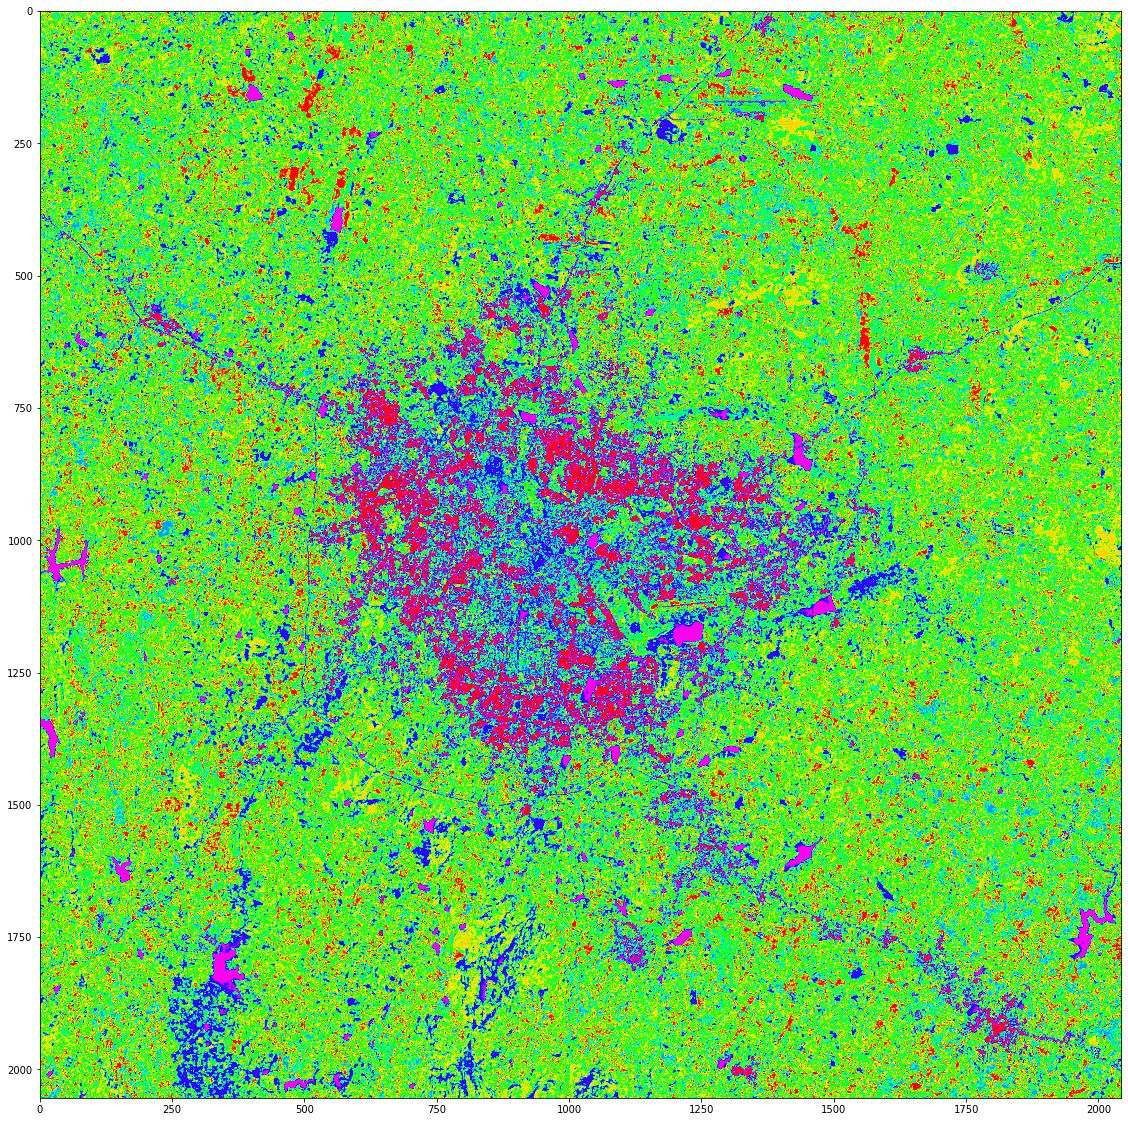

In [21]:
# Plot it
plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")

plt.show()

In [22]:
# Final save the result to a bew geotiff

from osgeo import gdal, gdal_array

## write out to tiff
### single band raster. 

ds = gdal.Open('l5_Bangalore2011_raw.tif')
band = ds.GetRasterBand(2)
arr = band.ReadAsArray()
[cols, rows] = arr.shape

format = "GTiff"
driver = gdal.GetDriverByName(format)


outDataRaster = driver.Create("k_means.tif", rows, cols, 1, gdal.GDT_Byte)
outDataRaster.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outDataRaster.SetProjection(ds.GetProjection())##sets same projection as input


outDataRaster.GetRasterBand(1).WriteArray(X_cluster)

outDataRaster.FlushCache() ## remove from memory
del outDataRaster ## delete the data (not the actual geotiff)